## Problem Statement: 

In this we are analysing positive and negative reviews by using different classification models. 

In [8]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [6]:
!pip install textblob
from textblob import TextBlob
from textblob import Word


In [9]:
# Importing dataset
imbd_data = pd.read_csv("movie.csv")

In [10]:
imbd_data.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


#### Exploratory data analysis 

In [11]:
imbd_data.describe()

,label
count,40000.000000
mean,0.499525
std,0.500006
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [13]:
imbd_data.shape

(40000, 2)

In [14]:
imbd_data.isnull().sum()

text     0
label    0
dtype: int64

#### Sentiment count
- 0: Negative
- 1: Positive

In [17]:
imbd_data['label'].value_counts()

0    20019
1    19981
Name: label, dtype: int64

#### Splitting the training dataset

In [21]:
train_reviews = imbd_data.text[:35000]
train_sentiments = imbd_data.label[:35000]

test_reviews = imbd_data.text[35000:] 
test_sentiments=imbd_data.label[35000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(35000,) (35000,)
(5000,) (5000,)


#### Text normalization

In [24]:
#Tokenization of text
tokenizer=ToktokTokenizer()

In [27]:
#Setting English stopwords
import nltk
nltk.download('stopwords')
stopword_list=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


#### Removing html strips and noise text

In [28]:
#Removing the html strip
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [32]:
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
imbd_data['review']=imbd_data['text'].apply(denoise_text)

C:\Users\DELL\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


#### Removing special characters

In [35]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imbd_data['review']=imbd_data['text'].apply(remove_special_characters)

#### Text stemming 

In [36]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imbd_data['review']=imbd_data['text'].apply(simple_stemmer)

#### Removing stopwords

In [39]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
imbd_data['review']=imbd_data['text'].apply(remove_stopwords)

{"you'd", 'by', "doesn't", 'are', 's', 'y', "wouldn't", 'under', 'their', 'hadn', 'won', 'out', "you'll", 'be', 'up', "isn't", 'why', 'these', 'theirs', 'a', 'between', 'some', 'mustn', 'then', 'have', 'where', 'myself', 'herself', "wasn't", "you're", 'its', "should've", 'other', 'which', 'isn', 'you', 'hers', 'did', 'during', 'only', 'so', 'didn', 'hasn', 'ours', 'our', 'does', 've', 'wouldn', "don't", 'once', 'been', 'on', 'ma', 'more', 'wasn', 'nor', 'down', 'while', 'further', 'to', "won't", "you've", 'i', 'same', 'yourselves', 'very', "haven't", 'too', 'yours', 'being', 'now', 'just', "weren't", 'him', 'having', 're', 'ain', 'who', 'all', 'himself', 'again', 'but', 'ourselves', 'couldn', 'of', 'don', 'or', 'not', 'against', 'about', 'd', "couldn't", "hasn't", 'because', 'above', 'my', "hadn't", 'each', 'shan', 'after', 'me', 'she', 'his', 't', 'do', 'and', 'until', 'that', 'should', 'few', 'whom', 'when', 'haven', 'such', 'the', 'her', 'them', 'off', 'how', 'doesn', 'was', 'doing'

#### Normalized train reviews

In [40]:
#normalized train reviews
norm_train_reviews=imbd_data.review[:35000]
norm_train_reviews[0]
#convert dataframe to string
#norm_train_string=norm_train_reviews.to_string()
#Spelling correction using Textblob
#norm_train_spelling=TextBlob(norm_train_string)
#norm_train_spelling.correct()
#Tokenization using Textblob
#norm_train_words=norm_train_spelling.words
#norm_train_words

'grew ( b. 1965 ) watching loving Thunderbirds. mates school watched. played " Thunderbirds " school , lunch school. wanted Virgil Scott. one wanted Alan. Counting 5 became art form. took children see movie hoping would get glimpse loved child. bitterly disappointing. high point snappy theme tune. could compare original score Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns series Gerry Anderson wife created. Jonatha Frakes hand directors chair , version completely hopeless. waste film. Utter rubbish. CGI remake may acceptable replacing marionettes Homo sapiens subsp. sapiens huge error judgment .'

#### Normalized test reviews

In [42]:
#Normalized test reviews
norm_test_reviews=imbd_data.review[35000:]
norm_test_reviews[35005]
##convert dataframe to string
#norm_test_string=norm_test_reviews.to_string()
#spelling correction using Textblob
#norm_test_spelling=TextBlob(norm_test_string)
#print(norm_test_spelling.correct())
#Tokenization using Textblob
#norm_test_words=norm_test_spelling.words
#norm_test_words

"Giorgino long , excruciating journey bad worse life protagonist movie named. Young demobilized , gas-poisoned First World War lieutenant delicate health , previously doctor orphanage children mental deprivations , goes search new location finds much ever intended quite different nature. Depressive atmosphere ultimate despair , insane ones much less horrible sane , madness kind poetry , hold hypnotized first frames film last. beauty : beauty winter mountains , beauty snowy landscapes wild woods , ' even know sorrow sadness last days war could made beautiful ."

#### Bags of words model

It is used to convert text documents to numerical vectors or bag of words.

In [44]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (35000, 5744034)
BOW_cv_test: (5000, 5744034)


#### Term Frequency-Inverse Document Frequency model (TFIDF)

It is used to convert text documents to matrix of tfidf features.

In [45]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (35000, 5744034)
Tfidf_test: (5000, 5744034)


#### Labeling the sentiment text

In [49]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(imbd_data['label'])
print(sentiment_data.shape)

(40000, 1)


#### Split the sentiment data

In [52]:
#Spliting the sentiment data
train_sentiments=sentiment_data[:35000]
test_sentiments=sentiment_data[35000:]
print(train_sentiments)
print(test_sentiments)

[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
[[1]
 [1]
 [1]
 ...
 [0]
 [1]
 [1]]


#### Modelling dataset

- Let us build logistic regression model for both bag of words and tfidf features

In [53]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


#### Logistic regression model performane on test dataset

In [54]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[1 1 1 ... 0 1 1]
[0 1 1 ... 0 1 1]


#### Accuracy of the model

In [55]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.7636
lr_tfidf_score : 0.7592


#### Print Classification report

In [56]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.76      0.77      0.76      2496
    Negative       0.77      0.76      0.76      2504

    accuracy                           0.76      5000
   macro avg       0.76      0.76      0.76      5000
weighted avg       0.76      0.76      0.76      5000

              precision    recall  f1-score   support

    Positive       0.74      0.79      0.77      2496
    Negative       0.78      0.73      0.75      2504

    accuracy                           0.76      5000
   macro avg       0.76      0.76      0.76      5000
weighted avg       0.76      0.76      0.76      5000



#### Confusion Matrix

In [57]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[1896  608]
 [ 574 1922]]
[[1818  686]
 [ 518 1978]]


#### Stochastic gradient descent or Linear support vector machines for bag of words and tfidf features

In [58]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,train_sentiments)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments)
print(svm_tfidf)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(max_iter=500, random_state=42)


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(max_iter=500, random_state=42)


#### Model performance on test data

In [59]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


#### Accuracy of the model

In [60]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.5086
svm_tfidf_score : 0.4992


#### Print the classification report

In [61]:
#Classification report for bag of words 
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)
#Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.50      1.00      0.67      2496
    Negative       1.00      0.02      0.04      2504

    accuracy                           0.51      5000
   macro avg       0.75      0.51      0.35      5000
weighted avg       0.75      0.51      0.35      5000

              precision    recall  f1-score   support

    Positive       0.50      1.00      0.67      2496
    Negative       0.00      0.00      0.00      2504

    accuracy                           0.50      5000
   macro avg       0.25      0.50      0.33      5000
weighted avg       0.25      0.50      0.33      5000



C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Plot the confusion matrix

In [62]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,svm_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[  47 2457]
 [   0 2496]]
[[   0 2504]
 [   0 2496]]


#### Multinomial Naive Bayes for bag of words and tfidf features

In [63]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


#### Model performance on test data

In [64]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[1 1 1 ... 0 1 1]
[1 1 1 ... 0 1 1]


#### Accuracy of the model

In [65]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.7638
mnb_tfidf_score : 0.762


#### Print the classification report

In [66]:
#Classification report for bag of words 
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.76      0.77      0.77      2496
    Negative       0.77      0.76      0.76      2504

    accuracy                           0.76      5000
   macro avg       0.76      0.76      0.76      5000
weighted avg       0.76      0.76      0.76      5000

              precision    recall  f1-score   support

    Positive       0.76      0.77      0.76      2496
    Negative       0.77      0.75      0.76      2504

    accuracy                           0.76      5000
   macro avg       0.76      0.76      0.76      5000
weighted avg       0.76      0.76      0.76      5000



#### Plot the confusion matrix

In [67]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[1893  611]
 [ 570 1926]]
[[1877  627]
 [ 563 1933]]


#### Let us see positive and negative words by using WordCloud.

#### Word cloud for positive review words

<function matplotlib.pyplot.show(close=None, block=None)>

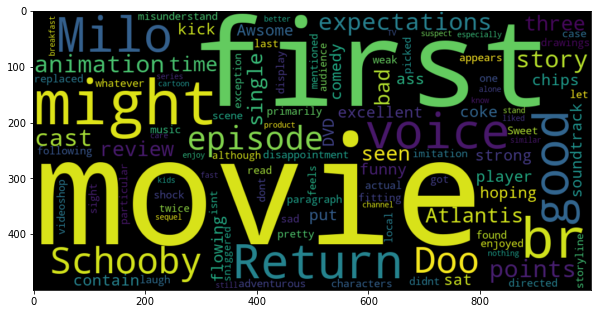

In [68]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

#### Word cloud for negative review words

<function matplotlib.pyplot.show(close=None, block=None)>

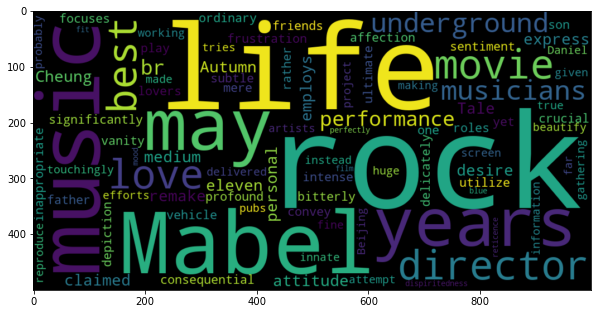

In [69]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

## Conclusion

#### We can observed that both logistic regression and multinomial naive bayes model performing well compared to linear support vector machines.